In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import shutil
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
CONTENT_DIR = '/kaggle/content'

TRAIN_DIR = CONTENT_DIR + '/train'
TRAIN_DIR_DOG = TRAIN_DIR + '/dog'
TRAIN_DIR_CAT = TRAIN_DIR + '/cat'

VALID_DIR = CONTENT_DIR + '/valid'
VALID_DIR_DOG = VALID_DIR + '/dog'
VALID_DIR_CAT = VALID_DIR + '/cat'

In [4]:
import zipfile
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zipf:
    zipf.extractall(CONTENT_DIR)

In [5]:
img_filenames = os.listdir(TRAIN_DIR)
print('Num of images:', len(img_filenames))

dog_filenames = [fn for fn in img_filenames if fn.startswith('dog')]
cat_filenames = [fn for fn in img_filenames if fn.startswith('cat')]

dataset_filenames = train_test_split(
    dog_filenames, cat_filenames, test_size=0.1, shuffle=True, random_state=42
)

train_dog_total, valid_dog_total, train_cat_total, valid_cat_total = [len(fns) for fns in dataset_filenames]
train_total = train_dog_total + train_cat_total
valid_total = valid_dog_total + valid_cat_total
print('Train: {}, test: {}'.format(train_total, valid_total))

Num of images: 25000
Train: 22500, test: 2500


In [6]:
make_dirs = [TRAIN_DIR_DOG, VALID_DIR_DOG, TRAIN_DIR_CAT, VALID_DIR_CAT]
for dir, fns in zip(make_dirs, dataset_filenames):
    os.makedirs(dir, exist_ok=True)
    for fn in tqdm.tqdm(fns):
        shutil.move(os.path.join(TRAIN_DIR, fn), dir)
    print('elements in {}: {}'.format(dir, len(os.listdir(dir))))

100%|██████████| 11250/11250 [00:00<00:00, 17048.99it/s]


elements in /kaggle/content/train/dog: 11250


100%|██████████| 1250/1250 [00:00<00:00, 18102.99it/s]


elements in /kaggle/content/valid/dog: 1250


100%|██████████| 11250/11250 [00:00<00:00, 17803.62it/s]


elements in /kaggle/content/train/cat: 11250


100%|██████████| 1250/1250 [00:00<00:00, 18583.60it/s]

elements in /kaggle/content/valid/cat: 1250


In [7]:
# Load training and validation sets

image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
ds_train = image_generator.flow_from_directory(
    directory='/kaggle/content/train/',
    target_size=(128, 128),
    batch_size=128,
    shuffle=True,
    class_mode='binary'
)
valid_generator = ImageDataGenerator(rescale=1./255)
ds_valid = valid_generator.flow_from_directory(
    directory='/kaggle/content/valid/',
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]),
    layers.MaxPool2D(pool_size=2, strides=2),

    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2),

    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2),
    
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPool2D(pool_size=2, strides=2),
    
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax'),
])


In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=60,
    callbacks=[early_stopping],

)

Epoch 1/60


2024-09-11 13:54:48.986134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


176/176 [==============================] - 138s 749ms/step - loss: 0.6792 - accuracy: 0.5594 - val_loss: 0.6677 - val_accuracy: 0.5728
Epoch 2/60
176/176 [==============================] - 126s 715ms/step - loss: 0.6219 - accuracy: 0.6493 - val_loss: 0.5605 - val_accuracy: 0.7124
Epoch 3/60
176/176 [==============================] - 127s 721ms/step - loss: 0.5765 - accuracy: 0.6971 - val_loss: 0.5080 - val_accuracy: 0.7488
Epoch 4/60
176/176 [==============================] - 129s 730ms/step - loss: 0.5387 - accuracy: 0.7264 - val_loss: 0.5204 - val_accuracy: 0.7396
Epoch 5/60
176/176 [==============================] - 128s 728ms/step - loss: 0.5119 - accuracy: 0.7484 - val_loss: 0.4812 - val_accuracy: 0.7828
Epoch 6/60
176/176 [==============================] - 129s 733ms/step - loss: 0.4822 - accuracy: 0.7683 - val_loss: 0.3910 - val_accuracy: 0.8312
Epoch 7/60
176/176 [==============================] - 128s 729ms/step - loss: 0.4535 - accuracy: 0.7876 - val_loss: 0.3763 - val_accura

Best Validation Loss: 0.1279
Best Validation Accuracy: 0.9504


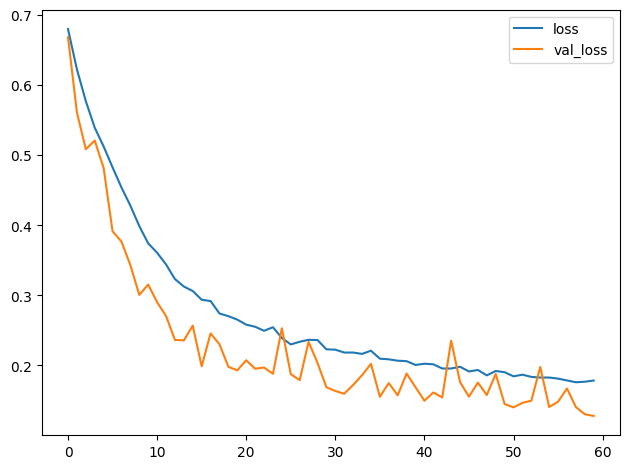

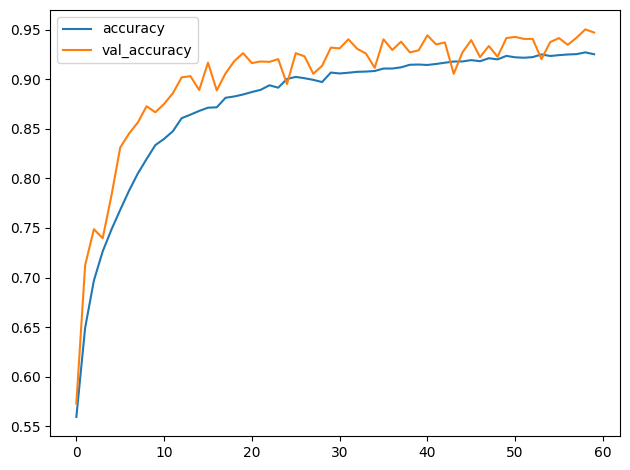

In [16]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_frame['val_loss'].min(), 
              history_frame['val_accuracy'].max()))